In [22]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.shared.config import EFFICIENCY

def derive_soc_from_trades(
    trade_df: pd.DataFrame, efficiency: EFFICIENCY, start_of_day, end_of_day
):
    """
    Derive State-of-Charge (SoC) from trade data.
    This function processes a DataFrame of trades to summarise the net position,
    volume, and price-weighted average (VWAP) for each product over a specified
    time period. It calculates the SoC based on the net charge and discharge
    volumes, and returns a DataFrame indexed by 15-minute intervals.

    Args:
        trade_df (pd.DataFrame): DataFrame containing trade data with columns:
            - "product": timestamp of the product in seconds
            - "side": "buy" or "sell"
            - "quantity": volume of the trade
            - "price": price of the trade
        efficiency (float): Efficiency factor for charge/discharge calculations.
        start_of_day (int): Start of the day in seconds since epoch.
        end_of_day (int): End of the day in seconds since epoch.

    Returns:
        pd.DataFrame: DataFrame indexed by 15-minute intervals with columns:
            - "sell_volume": total volume of sell trades
            - "buy_volume": total volume of buy trades
            - "net_position": net position (buy - sell)
            - "net_discharge": total discharge volume
            - "net_charge": total charge volume
            - "vwap_sell": volume-weighted average price for sell trades
            - "vwap_buy": volume-weighted average price for buy trades
            - "pnl": profit and loss based on VWAPs and volumes
            - "soc": state of charge calculated from net charge/discharge
    """
    trade_df = trade_df.copy()
    trade_df["product"] = [
        pd.to_datetime(x, unit="s", utc=True).tz_convert("Europe/Berlin")
        for x in trade_df["product"]
    ]
    grouped_by_product = trade_df.groupby("product")

    per_product_data = {}

    for idx, product_df in grouped_by_product:
        if product_df.empty:
            continue
        product = product_df["product"].iloc[0]
        sells = product_df[product_df["side"] == "sell"]
        sell_volume = sells["quantity"].sum()
        buys = product_df[product_df["side"] == "buy"]
        buy_volume = buys["quantity"].sum()

        net_position = (-1) * sell_volume + buy_volume

        sell_q = sells["quantity"].sum()
        buy_q  = buys["quantity"].sum()

        vwap_sell = (sells["quantity"] * sells["price"]).sum() / sell_q if sell_q != 0 else np.nan
        vwap_buy  = (buys["quantity"] * buys["price"]).sum() / buy_q  if buy_q  != 0 else np.nan

        pnl = buy_volume * (-1) * vwap_buy + sell_volume * vwap_sell

        net_charge = 0
        net_discharge = 0
        if net_position >= 0:
            net_charge = net_position
        else:
            net_discharge = (-1) * net_position

        per_product_data.update(
            {
                product: {
                    "sell_volume": sell_volume,
                    "buy_volume": buy_volume,
                    "net_position": net_position,
                    "net_discharge": net_discharge,
                    "net_charge": net_charge,
                    "vwap_sell": vwap_sell,
                    "vwap_buy": vwap_buy,
                    "pnl": pnl,
                }
            }
        )

    per_product_data_df = pd.DataFrame.from_dict(per_product_data).T
    start_of_day = pd.to_datetime(start_of_day, unit="s", utc=True).tz_convert(
        "Europe/Berlin"
    )
    end_of_day = pd.to_datetime(end_of_day, unit="s", utc=True).tz_convert(
        "Europe/Berlin"
    ) + pd.Timedelta(minutes=15)

    per_product_data_df = per_product_data_df.reindex(
        pd.date_range(start_of_day, end_of_day, freq="15min"), fill_value=0.0
    )
    per_product_data_df["soc"] = (
        per_product_data_df["net_charge"] + (-1) * per_product_data_df["net_discharge"]
    ).cumsum()
    per_product_data_df = per_product_data_df.shift(1).fillna(0)
    per_product_data_df.index = [x.timestamp() for x in per_product_data_df.index]
    return per_product_data_df


In [23]:
# Custom color palette
colors = {
    "pastel_burgundy": "#5EBEC4",
    "light_blue": "#F92C85",
    "pastel_green": "#F67EB7",
    "pastel_yellow": "#9CD4D8",
}

# ACM paper text dimensions (in inches)
page_width = 7.09
page_height = 9.25

In [24]:
def align_to_date(df, target_date):
    """
    Reindex a DataFrame to a specific target date while preserving time-of-day. USed for aligning daily data across 24 hours.

    Args:
        df (pd.DataFrame): DataFrame with a DateTimeIndex.
        target_date (str): Target date in "YYYY-MM-DD" format.

    Returns:
        pd.DataFrame: DataFrame reindexed to the target_date, with the original
        time-of-day preserved. If fewer than 24 timestamps are present, the result
        is padded to 24 hourly values.
    """
    times = df.index.strftime("%H:%M:%S")
    new_index = pd.to_datetime(target_date + " " + times)
    df = df.set_index(new_index)

    if len(times) < 24:
        new_index = pd.date_range(start=new_index.min(), periods=24, freq="H")
        df = df.reindex(new_index)

    return df

In [25]:
def set_acm_plot_style():
    """
    Apply ACM-compatible LaTeX plot styling to matplotlib.

    This function modifies the global matplotlib `rcParams` to use LaTeX
    rendering, Libertine font, and formatting compatible with ACM publications.
    """
    plt.rcParams.update(
        {
            "pgf.texsystem": "pdflatex",
            "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage{libertine}\usepackage{textcomp}\newcommand{\euro}{\texteuro}",
            "font.family": "serif",
            "font.size": 9,
            "legend.fontsize": 8,
            "text.usetex": False,
            "pgf.rcfonts": False,
        }
    )

In [26]:
def add_soc_statistics(df):
    """
    Add descriptive statistics to a DataFrame containing State-of-Charge (SoC) values.

    Computes the mean and the 20th and 80th percentiles across columns for each row
    and adds them as new columns.

    Args:
        df (pd.DataFrame): DataFrame with SoC values, one column per trial/day.

    Returns:
        pd.DataFrame: Input DataFrame with additional columns:
            - "mean"
            - "0.2 quantile"
            - "0.8 quantile"
    """
    columns = df.columns
    df["mean"] = df[columns].mean(axis=1)
    df["0.2 quantile"] = df[columns].quantile(0.2, axis=1)
    df["0.8 quantile"] = df[columns].quantile(0.8, axis=1)
    return df

/var/folders/_v/82glj9rn4txdcw0s4q311l7c0000gn/T/ipykernel_42587/2537861250.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  soc_id_df[f"soc_{i}"] = soc_id
/var/folders/_v/82glj9rn4txdcw0s4q311l7c0000gn/T/ipykernel_42587/2537861250.py:200: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  soc_da_df[f"soc_{i}"] = soc_da
/var/folders/_v/82glj9rn4txdcw0s4q311l7c0000gn/T/ipykernel_42587/2537861250.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

ValueError: cannot reindex on an axis with duplicate labels

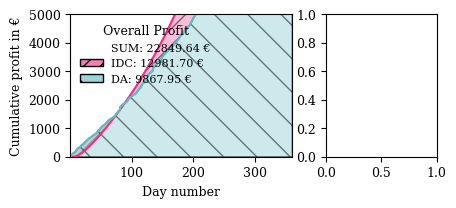

In [27]:
"""
Myopic Multi Market profit and State-of-Charge (SoC) plotting script for ACM e-Energy paper.

Generates:
1. A cumulative profit duration plot for Day-Ahead (DA) and Intraday Continuous (IDC) markets.
2. A State-of-Charge (SoC) comparison plot between DA and IDC strategies.


Requires:
- DA and IDC result CSVs for the naive strategy
- VWAP and trade files for SoC reconstruction

The script assumes a specific folder structure and preprocessed CSV data.
"""

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch, Polygon

idc = pd.DataFrame()
da = pd.DataFrame()

if __name__ == "__main__":
    set_acm_plot_style()

    path_da = Path("output/Resulting_data_with_cou_milp_non-binding/COU_5,3_optimal/single_market/day_ahead_milp/day_ahead_milp_results_2019-04-01_to_2020-03-27.csv")
    path_idc_base = Path(
        "output/Resulting_data_with_cou_milp_non-binding/COU_5,3_optimal/myopic_multi_market/rolling_intrinsic_stacked_on_day_ahead_qh/bs15cr1rto0.86mc365mt10"
    )

    # Day-Ahead profit: aggregate daily
    df_da = pd.read_csv(path_da)
    df_da.index = pd.to_datetime(df_da["time"], utc=True).dt.tz_convert("Europe/Berlin")
    df_da = df_da.drop_duplicates(keep="last")
    df_da["profit"] = df_da["discharge_revenues"] + df_da["charge_costs"]
    da_daily = df_da.groupby(df_da.index.date)["profit"].sum()

    # Intraday Continuous profit: clean & aggregate daily
    df_idc = pd.read_csv(path_idc_base / "profit.csv", parse_dates=["day"])
    df_idc = df_idc.drop_duplicates(subset="day", keep="last")
    df_idc["day"] = pd.to_datetime(df_idc["day"],utc=True)

    drop_dates = ["2020-11-15", "2020-12-27", "2020-12-31"]
    df_idc = df_idc[~df_idc["day"].dt.strftime("%Y-%m-%d").isin(drop_dates)]
    da_daily = da_daily[~da_daily.index.astype(str).isin(drop_dates)]
    idc_daily = df_idc.set_index(df_idc["day"].dt.date)["profit"]

    # Merge DA and IDC into one DataFrame
    profits = pd.merge(
        da_daily.sort_index()
        .reset_index()
        .rename(columns={"profit": "DA", "index": "date"}),
        idc_daily.sort_index()
        .reset_index()
        .rename(columns={"profit": "IDC", "day": "date"}),
        on="date",
        how="inner",
    ).set_index("date")

    profits = profits.sort_values(by="IDC", ascending=True)
    index_hours = range(1, len(profits) + 1)

    fig, axs = plt.subplots(
        1,
        2,
        figsize=(page_width / 1.5, page_height / 5),
        gridspec_kw={"width_ratios": [2, 1]},
    )

    # -----------------------------------
    # CUMULATIVE PROFIT PLOT
    # -----------------------------------
    overall_profit_idc = profits["IDC"].sum() - profits["DA"].sum()
    overall_profit_da = profits["DA"].sum()
    overall_profit = profits["IDC"].sum()

    hatch_legend = [
        Patch(
            facecolor="white", edgecolor="white", label=f"SUM: {overall_profit:.2f} €"
        ),
        Patch(
            facecolor=colors["pastel_green"],
            edgecolor="black",
            hatch="//",
            label=f"IDC: {overall_profit_idc:.2f} €",
        ),
        Patch(
            facecolor=colors["pastel_yellow"],
            edgecolor="black",
            hatch="\\",
            label=f"DA: {overall_profit_da:.2f} €",
        ),
    ]

    cumsum_IDC = profits["IDC"].cumsum()
    cumsum_DA = profits["DA"].cumsum()

    axs[0].plot(index_hours, cumsum_IDC, label="IDC Profit", color=colors["light_blue"])
    polygon_positive = Polygon(
        list(zip(index_hours, cumsum_IDC))
        + list(zip(index_hours[::-1], cumsum_DA[::-1])),
        closed=True,
        facecolor=colors["pastel_green"],
        edgecolor="black",
        hatch="//",
        alpha=0.5,
    )
    axs[0].add_patch(polygon_positive)

    axs[0].plot(
        index_hours, cumsum_DA, label="DA Profit", color=colors["pastel_burgundy"]
    )
    polygon_positive_da = Polygon(
        [(index_hours[0], 0)]
        + list(zip(index_hours, cumsum_DA))
        + [(index_hours[-1], 0)],
        closed=True,
        facecolor=colors["pastel_yellow"],
        edgecolor="black",
        hatch="\\",
        alpha=0.5,
    )
    axs[0].add_patch(polygon_positive_da)

    axs[0].set_xlabel("Day number")
    axs[0].set_ylabel("Cumulative profit in €")
    axs[0].legend(
        handles=hatch_legend, loc="upper left", title="Overall Profit", frameon=False
    )
    axs[0].margins(0)
    axs[0].set_ylim(0, 5000)

    # -----------------------------------
    # STATE OF CHARGE (SOC) PLOT
    # -----------------------------------
    target_date = "2020-01-01"
    soc_id_df = pd.DataFrame()
    soc_da_df = pd.DataFrame()

    for i, date in enumerate(idc_daily.index):
        date = date + pd.Timedelta(days= 1)
        path_trades = path_idc_base / f"trades/trades_{date}.csv"
        trades = pd.read_csv(path_trades, index_col=0)
        trades.index = (
            pd.to_datetime(trades.index, utc=True)
            .tz_convert("Europe/Berlin")
            .astype("int64")
            // 10**9
        )
        trades["product"] = (
            pd.to_datetime(trades["product"], utc=True)
            .dt.tz_convert("Europe/Berlin")
            .astype("int64")
            // 10**9
        )

        path_vwaps = path_idc_base / f"vwap/vwaps_{date}.csv"
        vwaps = pd.read_csv(path_vwaps, index_col=0)

        date_vwaps = pd.to_datetime(vwaps.index[0]).date()
        vwaps = vwaps.iloc[:, :96]
        vwaps.columns = pd.date_range(date_vwaps, periods=96, freq="15T")
        vwaps.index = (
            pd.to_datetime(vwaps.index, utc=True)
            .tz_convert("Europe/Berlin")
            .astype("int64")
            // 10**9
            - 900
        )
        vwaps.columns = (
            pd.to_datetime(vwaps.columns, utc=True)
            .tz_convert("Europe/Berlin")
            .astype("int64")
            // 10**9
        )
        vwaps = vwaps.T.sort_index()
        if trades.empty:
            continue

        soc_id = derive_soc_from_trades(trades, 1, vwaps.columns[0], vwaps.columns[-1])[
            "soc"
        ]
        soc_id = pd.DataFrame(soc_id / 4 * 100).iloc[32:]
        soc_id.index = pd.to_datetime(soc_id.index, unit="s", utc=True).tz_convert(
            "Europe/Berlin"
        )
        soc_id = align_to_date(soc_id, target_date)
        soc_id_df[f"soc_{i}"] = soc_id

        soc_da = pd.DataFrame(df_da["soc"][df_da.index.date == date] * 100)
        soc_da = align_to_date(soc_da, target_date)
        soc_da_df[f"soc_{i}"] = soc_da
        date = date - pd.Timedelta(days= 1)

        idc = pd.concat([idc, soc_id], axis=1)
        da = pd.concat([da, soc_da], axis=1)


    soc_id_df = add_soc_statistics(soc_id_df)
    soc_da_df = add_soc_statistics(soc_da_df)





    axs[1].fill_betweenx(
        soc_id_df.index,
        soc_id_df["0.2 quantile"],
        soc_id_df["0.8 quantile"],
        color=colors["pastel_green"],
        alpha=0.5,
        label="Quantiles IDC",
    )
    axs[1].plot(
        soc_id_df["mean"],
        soc_id_df.index,
        label="Mean IDC",
        color=colors["light_blue"],
        linewidth=1.5,
    )

    axs[1].fill_betweenx(
        soc_da_df.index,
        soc_da_df["0.2 quantile"],
        soc_da_df["0.8 quantile"],
        color=colors["pastel_yellow"],
        alpha=0.5,
        label="Quantiles DA",
    )
    axs[1].plot(
        soc_da_df["mean"],
        soc_da_df.index,
        label="Mean DA",
        color=colors["pastel_burgundy"],
        linewidth=1.5,
    )

    axs[1].set_xlabel("State of Charge in %")
    axs[1].set_xticks(np.arange(0, 101, 50))
    axs[1].set_xlim(0, 100)

    date_range = pd.date_range(
        soc_da_df.index[0], soc_da_df.index[-1] + pd.Timedelta(minutes=15), freq="2H"
    )
    axs[1].set_yticks(date_range)
    axs[1].set_yticklabels(date_range.strftime("%H:%M"))
    axs[1].set_ylim(date_range[0], date_range[-1])

    # Clean up duplicated legend entries
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[1].legend(by_label.values(), by_label.keys(), loc="lower right")

    plt.tight_layout()
    plt.show()

In [31]:
idc, da

(                           soc        soc   soc  soc        soc  soc  \
 2020-01-01 00:00:00   0.000000   0.000000   0.0  0.0   0.000000  0.0   
 2020-01-01 00:15:00   0.000000   0.000000   0.0  0.0   0.000000  0.0   
 2020-01-01 00:30:00   0.000000   0.000000   0.0  0.0   0.000000  0.0   
 2020-01-01 00:45:00   0.000000   0.000000   0.0  0.0  25.000000  0.0   
 2020-01-01 01:00:00   0.000000   0.000000  25.0  0.0  25.000000  0.0   
 ...                        ...        ...   ...  ...        ...  ...   
 2020-01-01 22:45:00  22.139535  20.348837  25.0  0.0   4.069767  3.5   
 2020-01-01 23:00:00  22.139535  20.348837  25.0  0.0   4.069767  3.5   
 2020-01-01 23:15:00  22.139535  20.348837  14.0  0.0   4.069767  3.5   
 2020-01-01 23:30:00  22.139535  20.348837  14.0  0.0   4.069767  3.5   
 2020-01-01 23:45:00  22.139535  20.348837  14.0  0.0   4.069767  3.5   
 
                            soc           soc   soc  soc  ...        soc  soc  \
 2020-01-01 00:00:00   0.000000  0.000000

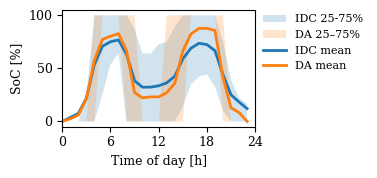

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime index
idc.index = pd.to_datetime(idc.index)
da.index = pd.to_datetime(da.index)

# Clip SoC to [0, 100] (%). Everything above 100 is cut off.
idc_clip = idc
da_clip = da

# Align both to the same time-of-day index (robust if one has missing stamps)
idc_clip, da_clip = idc_clip.align(da_clip, join="inner", axis=0)

# x-axis: hours since midnight (0..24)
hours = (idc_clip.index - idc_clip.index.normalize()).total_seconds() / 3600.0

# Mean across days
idc_mean = idc_clip.mean(axis=1)
da_mean = da_clip.mean(axis=1)

# Spread band: central 50% (25th to 75th percentile)
idc_q10 = idc_clip.quantile(0.25, axis=1)
idc_q90 = idc_clip.quantile(0.75, axis=1)
da_q10 = da_clip.quantile(0.25, axis=1)
da_q90 = da_clip.quantile(0.75, axis=1)

fig, ax = plt.subplots(figsize=(page_width / 1.5, page_height / 5))

# Quantile bands (central 80%)
ax.fill_between(hours, idc_q10, idc_q90, alpha=0.20, label="IDC 25-75%")
ax.fill_between(hours, da_q10, da_q90, alpha=0.20, label="DA 25–75%")

# Mean lines
ax.plot(hours, idc_mean, linewidth=2.0, label="IDC mean")
ax.plot(hours, da_mean, linewidth=2.0, label="DA mean")

ax.set_xlim(0, 24)
ax.set_xticks([0, 6, 12, 18, 24])
ax.set_xlabel("Time of day [h]")

ax.set_ylim()
ax.set_ylabel("SoC [%]")

# Legend outside the axes (to the right)
ax.legend(
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)
ax.margins(x=0)
# Leave room on the right for the outside legend
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()